Get measurements for mean cell area and fluorescence

In [1]:
import pandas as pd
import os
from skimage.io import imread
import numpy as np
from sklearn.metrics import  mean_absolute_error, mean_squared_error, root_mean_squared_error
import tifffile as tiff
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from utils.eval_plots_utils import w_gt_process_data
from scipy.stats import ttest_ind


from utils.eval_plots_utils import *

pd.set_option('display.max_rows', None)


# Function to process data from CSV files and split into 'before' and 'after'
def process_data_with_fluorescence_split(file_paths):
    all_data = []
    
    for exp, models_dict in file_paths.items():
        for model, file_path in models_dict.items():
            
            df = pd.read_csv(file_path)
            
            # Assume rows alternate between 'before' and 'after'
            before_df = df.iloc[::2].copy()  # Take every other row starting from the first
            after_df = df.iloc[1::2].copy()  # Take every other row starting from the second
            
            before_df['Condition'] = 'Before'  # New column to indicate condition
            after_df['Condition'] = 'After'    # New column to indicate condition
            
            # Combine the before and after data
            combined_df = pd.concat([before_df, after_df], ignore_index=True)
            combined_df['Model'] = model
            combined_df['Experiment'] = exp
            
            all_data.append(combined_df)
    
    # Combine all the data into a single DataFrame
    return pd.concat(all_data, ignore_index=True)

In [2]:
# Construct nested dictionaries of results and segmentations for all models

base_path = '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/'

# Lists of experiments and models
exps = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5']
models = [
    'PHANTAST', 'finetuned_vit_l', 'finetuned_vit_l_lm', 'finetuned_vit_b', 'finetuned_vit_b_lm', 'cellpose3'
]
# Construct nested dictionaries of results and segmentations
results_csv_file_paths = {
    exp: {
        model: os.path.join(base_path, f'{exp}/Model_{model}/Results/Results.csv')
        for model in models
    }
    for exp in exps
}

masks_file_paths = {
    exp: {
        model: os.path.join(base_path, f'{exp}/Model_{model}/Segmentation_Output/Mask_Stack.tiff')
        for model in models
    }
    for exp in exps
}

print(results_csv_file_paths)
print(masks_file_paths)

{'exp1': {'PHANTAST': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_PHANTAST/Results/Results.csv', 'finetuned_vit_l': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_finetuned_vit_l/Results/Results.csv', 'finetuned_vit_l_lm': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_finetuned_vit_l_lm/Results/Results.csv', 'finetuned_vit_b': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_finetuned_vit_b/Results/Results.csv', 'finetuned_vit_b_lm': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_finetuned_vit_b_lm/Results/Results.csv', 'cellpose3': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_cellpose3/Results/Results.csv'}, 'exp2': {'PHANTAST': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp2/Model_PHANTAST/Results/Results.csv', 

In [3]:
# Get measurements for mean cell area and mean intensity (plus sds) for each model across experiments

results_df = process_data(results_csv_file_paths) 

numeric_columns = results_df.select_dtypes(include='number').columns # Ensure only numeric columns are included in the groupby operation
measurements_df = results_df.groupby('Model')[numeric_columns].mean().reset_index()
print("Mean Cell Area and Mean Inensity Measurements Per Model Across Experiments")
display(measurements_df)

Mean Cell Area and Mean Inensity Measurements Per Model Across Experiments


,Model,Mean Cell Area,Mean Intensity,Std Cell Area,Std Intensity
0,PHANTAST,610767.272,57.2900,209794.270,48.8440
1,cellpose3,438972.176,62.2040,144533.480,54.7260
2,finetuned_vit_b,783879.204,54.8460,189673.676,46.6720
3,finetuned_vit_b_lm,496865.232,57.0180,198844.272,48.6920
4,finetuned_vit_l,759615.296,56.1980,192993.124,48.3460
5,finetuned_vit_l_lm,112914.040,66.4475,152096.302,107.4925


In [4]:
# Access the CSV file path for 'finetuned_vit_l_lm' in 'exp1'
finetuned_vit_l_lm_exp1_path = results_csv_file_paths['exp1']['finetuned_vit_l_lm']

# Read the CSV file
df_finetuned_vit_l_lm_exp1 = pd.read_csv(finetuned_vit_l_lm_exp1_path)


print("Cell Area Measurements for 'finetuned_vit_l_lm' in 'exp1':")
print(df_finetuned_vit_l_lm_exp1.iloc[:, 1])

Cell Area Measurements for 'finetuned_vit_l_lm' in 'exp1':
0     273964
1      14082
2     671925
3       3552
4      20841
5     229263
6      77261
7      36630
8     600202
9      27442
10    159839
11    106005
12    193422
13     26617
14    100754
15     30884
16    119075
17     82105
18    114230
19     63608
20     55602
21     63991
22     83502
23      2879
24     78465
25    164768
26    135107
27     67447
28    108205
29    151358
30    147011
31     77238
32     51985
33     71532
34    180761
35      7393
36     50587
37     11605
38     45998
39    127575
40     25078
41    117433
42      2550
43     29763
44    102722
45     17678
46     20399
47    172575
48    160766
49     44980
Name: Area, dtype: int64


In [5]:
# Only do once

# def save_images_as_stack(directory, input_images, filename):
#     output_path = os.path.join(directory, filename)
#     tiff.imwrite(output_path, input_images)
# # Directory containing the images
# input_dir = '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/eval_test_data/normalised_test_labels'
# output_dir = '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/eval_test_data/Model_Ground_truth/Segmentation_Output'

# # Read and stack all images from input directory
# stacked_images = []
# for image_name in os.listdir(input_dir):
#     image_path = os.path.join(input_dir, image_name)
#     if image_name.endswith('.tiff') or image_name.endswith('.tif'):  # Ensure only TIFF images are read
#         images = tiff.imread(image_path)
#         stacked_images.append(images)

# # Convert list of images to stack and save
# save_images_as_stack(output_dir, stacked_images, 'Mask_Stack.tiff')

In [6]:
# Now repeat but including ground truth data

base_path = '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/eval_test_data'

# List of models
w_gt_models = [
    'PHANTAST', 'finetuned_vit_l', 'finetuned_vit_l_lm', 'finetuned_vit_b', 'finetuned_vit_b_lm', 'cellpose3', 'Ground_truth'
]
# Construct nested dictionaries of results and segmentations
w_gt_results_csv_file_paths = {
    model: os.path.join(base_path, f'Model_{model}/Results/Results.csv')
    for model in w_gt_models
}

w_gt_masks_file_paths = {
    model: os.path.join(base_path, f'Model_{model}/Segmentation_Output/Mask_Stack.tiff')
    for model in w_gt_models
}

print(w_gt_results_csv_file_paths)
print(w_gt_masks_file_paths)

w_gt_results_df = w_gt_process_data(w_gt_results_csv_file_paths) 

numeric_columns = w_gt_results_df.select_dtypes(include='number').columns # Ensure only numeric columns are included in the groupby operation
w_gt_measurements_df = w_gt_results_df.groupby('Model')[numeric_columns].mean().reset_index()
print("Mean Cell Area Per Model Across Segmentation Only Experiments")
display(w_gt_measurements_df)

{'PHANTAST': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/eval_test_data/Model_PHANTAST/Results/Results.csv', 'finetuned_vit_l': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/eval_test_data/Model_finetuned_vit_l/Results/Results.csv', 'finetuned_vit_l_lm': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/eval_test_data/Model_finetuned_vit_l_lm/Results/Results.csv', 'finetuned_vit_b': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/eval_test_data/Model_finetuned_vit_b/Results/Results.csv', 'finetuned_vit_b_lm': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/eval_test_data/Model_finetuned_vit_b_lm/Results/Results.csv', 'cellpose3': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/eval_test_data/Model_cellpose3/Results/Results.csv', 'Ground_truth': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_mod

,Model,Mean Cell Area,Mean Intensity,Std Cell Area,Std Intensity
0,Ground_truth,406404.99,NaN,270264.22,NaN
1,PHANTAST,338018.61,NaN,237916.60,NaN
2,cellpose3,126036.61,NaN,137283.75,NaN
3,finetuned_vit_b,536210.91,NaN,338617.47,NaN
4,finetuned_vit_b_lm,421173.53,NaN,289278.70,NaN
5,finetuned_vit_l,468448.89,NaN,316267.45,NaN
6,finetuned_vit_l_lm,417072.67,NaN,312605.40,NaN


In [9]:
# Data structure
results_df = pd.DataFrame({
    'Model': ['PHANTAST', 'cellpose3', 'finetuned_vit_b', 'finetuned_vit_b_lm', 'finetuned_vit_l', 'finetuned_vit_l_lm'],
    'Intensity Before': [57.29, 62.20, 54.85, 57.02, 56.20, 63.86],
    'Intensity After': [48.84, 54.73, 46.67, 48.69, 48.35, 98.70]
})

# Calculate the difference between 'Before' and 'After'
results_df['Difference'] = results_df['Intensity After'] - results_df['Intensity Before']

# Perform t-tests comparing PHANTAST to each other model
ph_diff = results_df.loc[results_df['Model'] == 'PHANTAST', 'Difference'].values

for model in results_df['Model'].unique():
    if model != 'PHANTAST':
        other_diff = results_df.loc[results_df['Model'] == model, 'Difference'].values
        t_stat, p_value = ttest_ind(ph_diff, other_diff, equal_var=False)  # Assuming unequal variance
        
        print(f"Comparison between PHANTAST and {model}:")
        print(f"t-statistic = {t_stat}, p-value = {p_value}\n")
        if p_value < 0.05:
            print(f"The difference between PHANTAST and {model} is statistically significant (p < 0.05).\n")
        else:
            print(f"The difference between PHANTAST and {model} is not statistically significant (p >= 0.05).\n")


Comparison between PHANTAST and cellpose3:
t-statistic = nan, p-value = nan

The difference between PHANTAST and cellpose3 is not statistically significant (p >= 0.05).

Comparison between PHANTAST and finetuned_vit_b:
t-statistic = nan, p-value = nan

The difference between PHANTAST and finetuned_vit_b is not statistically significant (p >= 0.05).

Comparison between PHANTAST and finetuned_vit_b_lm:
t-statistic = nan, p-value = nan

The difference between PHANTAST and finetuned_vit_b_lm is not statistically significant (p >= 0.05).

Comparison between PHANTAST and finetuned_vit_l:
t-statistic = nan, p-value = nan

The difference between PHANTAST and finetuned_vit_l is not statistically significant (p >= 0.05).

Comparison between PHANTAST and finetuned_vit_l_lm:
t-statistic = nan, p-value = nan

The difference between PHANTAST and finetuned_vit_l_lm is not statistically significant (p >= 0.05).



/vol/biomedic3/bglocker/mscproj24/nma23/miniforge3/envs/micro-sam/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1081: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/vol/biomedic3/bglocker/mscproj24/nma23/miniforge3/envs/micro-sam/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1081: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [10]:
# # DEBUGGING: manual check

# mask_stack = tiff.imread(masks_file_paths['exp2']['finetuned_vit_b'])
# cell_areas = [np.sum(mask_slice == 1) for mask_slice in mask_stack]

# # Convert to a numpy array to calculate mean and std
# cell_areas = np.array(cell_areas)

# mean_cell_area = np.mean(cell_areas)
# std_cell_area = np.std(cell_areas)

# print(f"Mean Cell Area: {mean_cell_area}, Std: {std_cell_area}")

# # Display first 4 slices of exp1 mask_stack for finetuned_vit_l_lm
# mask_stack = tiff.imread(masks_file_paths['exp5']['finetuned_vit_l_lm'])
# for mask in mask_stack[40:49]:
#     plt.figure()
#     plt.imshow(mask, cmap='gray')

In [11]:
# print(results_df.columns)


In [12]:
# Investigate before/after fluorescence data
results_df = process_data_with_fluorescence_split(results_csv_file_paths)

mean_std_df = results_df.groupby(['Model', 'Condition'])['Mean'].agg(['mean', 'std']).reset_index()

print("Mean and Standard Deviation of Fluorescence Before and After Per Model")
print(mean_std_df)


Mean and Standard Deviation of Fluorescence Before and After Per Model
                 Model Condition      mean         std
0             PHANTAST     After  35.88896   26.408738
1             PHANTAST    Before  78.69220   56.461621
2            cellpose3     After  39.06464   31.042550
3            cellpose3    Before  85.34572   63.282384
4      finetuned_vit_b     After  34.50160   25.838102
5      finetuned_vit_b    Before  75.19392   53.758698
6   finetuned_vit_b_lm     After  36.01156   26.767230
7   finetuned_vit_b_lm    Before  78.02740   56.218307
8      finetuned_vit_l     After  35.24936   26.885457
9      finetuned_vit_l    Before  77.14848   55.671693
10  finetuned_vit_l_lm     After  41.91725   74.070164
11  finetuned_vit_l_lm    Before  90.97545  147.160727


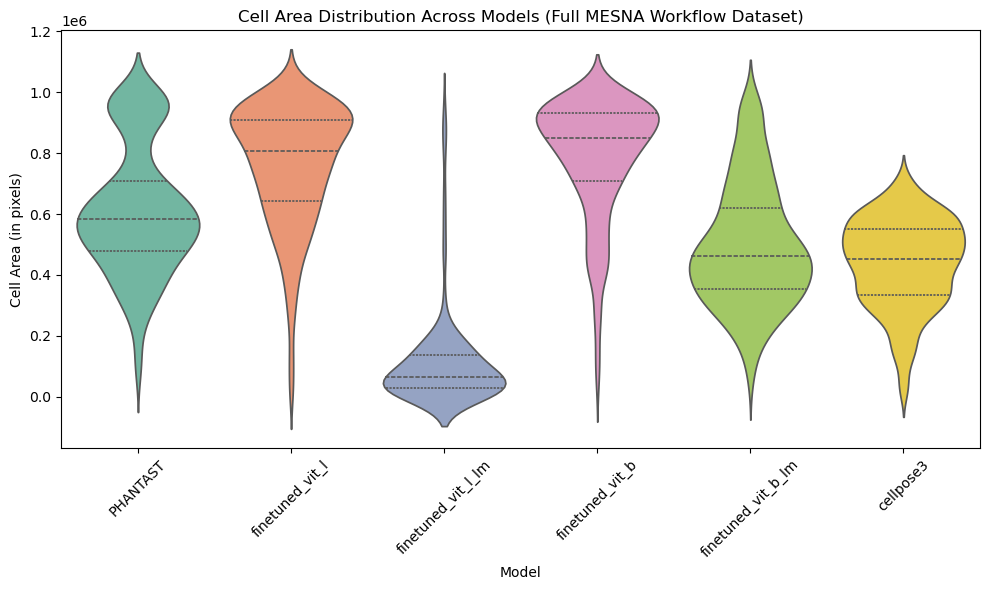

In [18]:
# Violin plots for cell area for segmentation only

# List to hold DataFrames for all models
cell_area_data = []

# Iterate over all experiments and models
for model in models:
    model_cell_areas = []  # Stores cell areas across all experiments for a specific model
    for exp in exps:
        mask_stack = tiff.imread(masks_file_paths[exp][model])
        cell_areas = [np.sum(mask_slice == 1) for mask_slice in mask_stack]
        model_cell_areas.extend(cell_areas)  # Concatenate cell areas across experiments
    
    # Create a DataFrame for the current model across all experiments
    model_df = pd.DataFrame({
        'Cell Area': model_cell_areas,
        'Model': model
    })
    cell_area_data.append(model_df)

all_data = pd.concat(cell_area_data, ignore_index=True)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='Cell Area', data=all_data, palette='Set2', inner='quartile', hue='Model', legend=False)
plt.title('Cell Area Distribution Across Models (Full MESNA Workflow Dataset)')
plt.ylabel('Cell Area (in pixels)')
plt.xlabel('Model')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


/tmp/ipykernel_2325900/3393305113.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model', y='Cell Area', data=all_data, palette='Set2', inner='quartile')


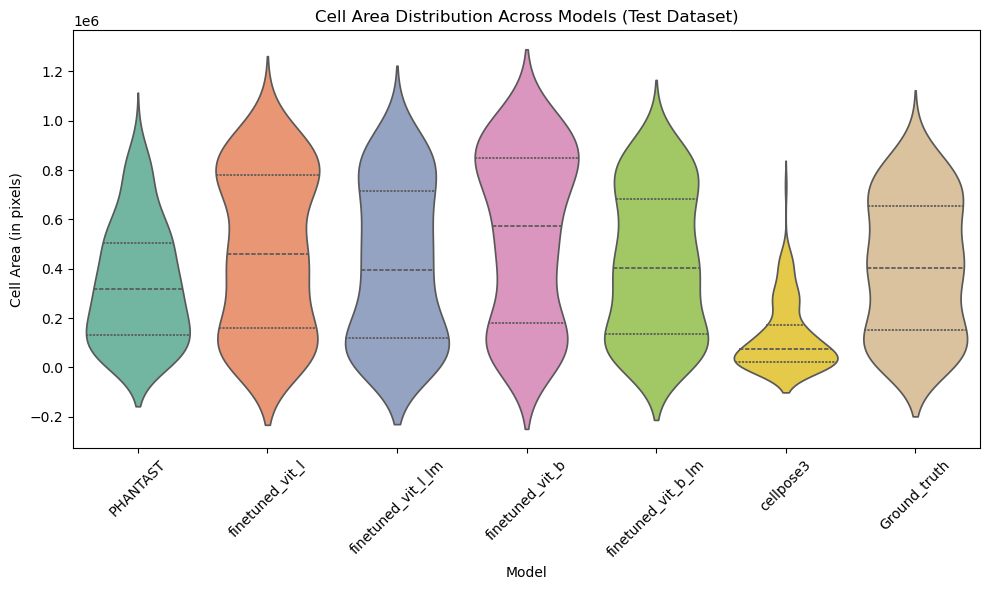

In [21]:
# Violin plots for cell area for segmentation only

cell_area_data = []

# Iterate over all models and calculate cell areas
for model in w_gt_models:
    model_cell_areas = []  # Stores cell areas for a specific model
    mask_stack = tiff.imread(w_gt_masks_file_paths[model])
    
    cell_areas = [np.sum(mask_slice == 1) for mask_slice in mask_stack]
    model_cell_areas.extend(cell_areas)  

    # Create a DataFrame for the current model being looped over
    model_df = pd.DataFrame({
        'Cell Area': model_cell_areas,
        'Model': model
    })
    cell_area_data.append(model_df)

all_data = pd.concat(cell_area_data, ignore_index=True)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='Cell Area', data=all_data, palette='Set2', inner='quartile')
plt.title('Cell Area Distribution Across Models (Test Dataset)')
plt.ylabel('Cell Area (in pixels)')
plt.xlabel('Model')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

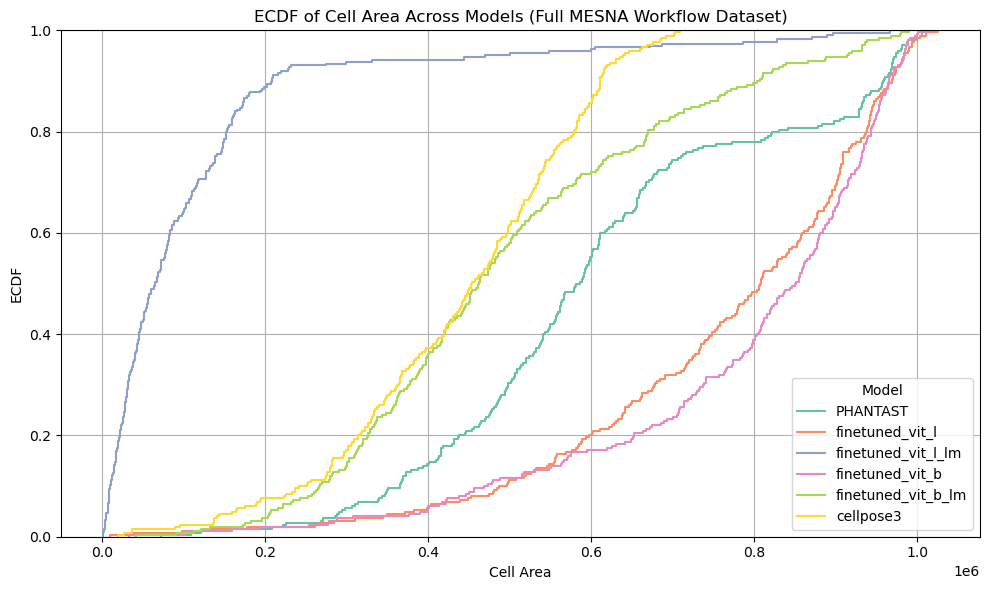

In [23]:
# Plot MESNA data as ECDF

# Uses individual points
def process_raw_data(file_paths_by_exp):
    results = []

    for exp, models in file_paths_by_exp.items():
        for model, file_path in models.items():

            df = pd.read_csv(file_path)
            
            if df.shape[1] > 2: 
                cell_areas = df.iloc[:, 1]  # Cell area is second column
                for area in cell_areas:
                    results.append({
                        'Experiment': exp,
                        'Model': model,
                        'Cell Area': area
                    })
            else:
                print(f"File {file_path} does not have enough columns")

    return pd.DataFrame(results)

# Settings to match violin plots
model_colors = sns.color_palette("Set2", len(models))
model_color_dict = dict(zip(models, model_colors))

# Process the raw data
results_raw_df = process_raw_data(results_csv_file_paths)

# Plot ECDF for each model using the raw cell area data
plt.figure(figsize=(10, 6))

# Loop over each model and plot ECDF for 'Cell Area'
for model in models:
    model_data = results_raw_df[results_raw_df['Model'] == model]  # Filter data for the current model
    sns.ecdfplot(model_data['Cell Area'], label=model, color=model_color_dict[model])

plt.title('ECDF of Cell Area Across Models (Full MESNA Workflow Dataset)')
plt.xlabel('Cell Area')
plt.ylabel('ECDF')
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()

plt.show()

